# calculate the Relative Oceanic Nino Index (RONI) from the daily OISST dataset 

#### contact: <nicolas.fauchereau@niwa.co.nz> 

## NOTE: 

### This notebook is adapted from Michelle L'Heureux's code for the calculation of the monthly RONI from ERSSTv5, available at https://github.com/michellelheureux/Relative-SST

### Many thanks to Michelle L'Heureux for providing multiple inputs, the suggestion to retain the low-frequency component of the SST climatologies, and pointing issues related to the 29th of February

In [1]:
date_run = !date

In [2]:
print(f"date run: {date_run[0]}") 

date run: Tue May 21 10:14:37 NZST 2024


### for updating, best is to use `update_OISST.ipynb` in `/mnt/c/Users/fauchereaun/operational/SST_forecasting/notebooks` 

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import pathlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
from dask.diagnostics import ProgressBar
import cftime
from datetime import date
from dateutil.relativedelta import relativedelta

In [5]:
%run -i ../src/OISST/OISST.py # can also pip install 

In [6]:
sst_t = 'daily' # or 'monthly'

In [7]:
dpath = pathlib.Path(f'/mnt/c/Users/fauchereaun/data/OISST/{sst_t}/global/') 

In [8]:
lfiles = list(dpath.glob(f"sst.???.mean.????.nc"))

In [9]:
lfiles.sort()

In [10]:
len(lfiles) 

44

In [11]:
lfiles[0]

PosixPath('/mnt/c/Users/fauchereaun/data/OISST/daily/global/sst.day.mean.1981.nc')

In [12]:
lfiles[-1]

PosixPath('/mnt/c/Users/fauchereaun/data/OISST/daily/global/sst.day.mean.2024.nc')

In [13]:
def extract_tropics(dset): 
    dset = dset.sortby('lat') 
    return dset.sel(lat=slice(-20, 20))

In [14]:
dset = xr.open_mfdataset(lfiles, parallel=True, preprocess=extract_tropics)

In [15]:
dset.nbytes / 1e9

14.378934416

### We retrieve the calendar, will be used later

In [16]:
standard_calendar = dset.time.to_index()

In [17]:
len(standard_calendar)

15602

In [18]:
standard_calendar[0]

Timestamp('1981-09-01 00:00:00')

In [19]:
standard_calendar[-1]

Timestamp('2024-05-19 00:00:00')

### convert the dataset to a 365 days calendar, to get rid of this pesky day of year problem 

In [20]:
dset = dset.convert_calendar('365_day')

In [21]:
len(dset.time)

15591

### Now each year has 365 days, and the day of year is consistent 

In [22]:
dset.time.dt.dayofyear.max()

<xarray.DataArray 'dayofyear' ()>
array(365)

### calculate the weights 

In [23]:
weights = np.cos(np.deg2rad(dset['lat']))
weights.name = "weights"

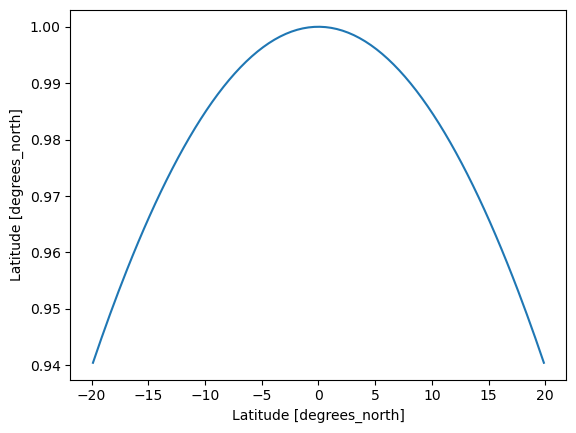

In [24]:
weights.plot()

### calculate the tropical averaged SSTs, un-weighted

#### Note: takes about 5 minutes, playing with the size of the chunks might help ... 

In [25]:
tropav = dset.mean(dim=('lat','lon'))

In [26]:
with ProgressBar(): 
    tropav = tropav.compute()

[########################################] | 100% Completed | 248.19 s


In [27]:
tropav = tropav.rename({'sst':'tropav'})

### Plot the tropical averaged SSTs, un-weigthed

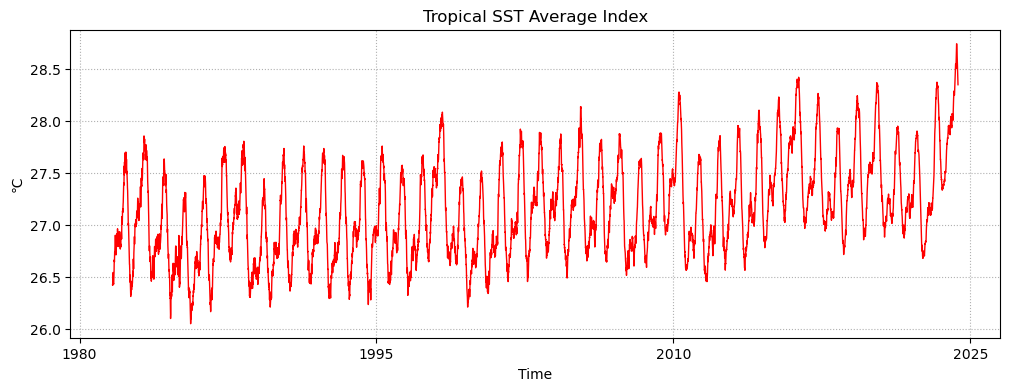

In [28]:
fig, ax = plt.subplots(figsize=(12, 4))
tropav.tropav.plot(ax=ax,x='time',linewidth=1,color='red')
plt.title('Tropical SST Average Index')
ax.grid(ls=':')
ax.set_ylabel('℃');

### calculate the tropical averaged SSTs, weighted by the cosine of the latitude 

In [29]:
tropav_weighted = dset['sst'].weighted(weights)

In [30]:
tropav_weighted = tropav_weighted.mean(("lon", "lat"))

In [31]:
tropav_weighted = tropav_weighted.to_dataset(name='tropav_weighted')

In [32]:
with ProgressBar(): 
    tropav_weighted = tropav_weighted.compute()

[########################################] | 100% Completed | 246.07 s


### Plot the tropical averaged SSTs, unweighted and weigthed 

Text(0.5, 1.0, 'Tropical SST Average Index')

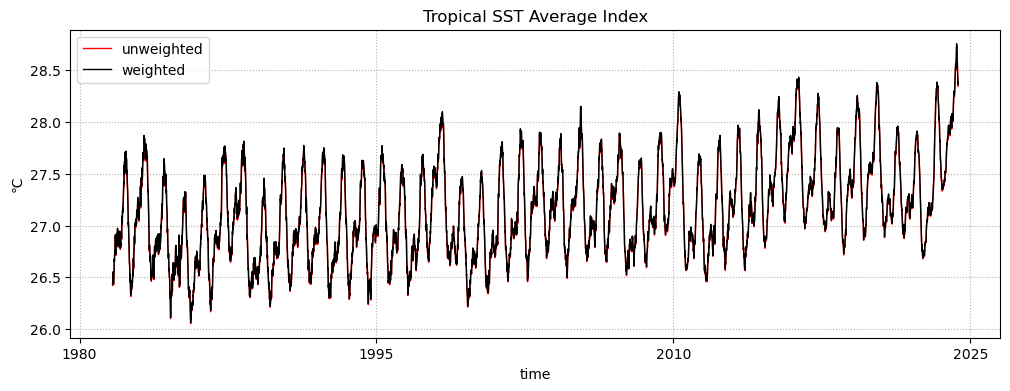

In [33]:
fig, ax = plt.subplots(figsize=(12, 4))
tropav.tropav.plot(ax=ax,x='time',linewidth=1,color='red', label = 'unweighted')
tropav_weighted.tropav_weighted.plot(ax=ax,x='time',linewidth=1,color='black', label = 'weighted')
ax.legend()
ax.grid(ls=':')
ax.set_ylabel('℃');
plt.title('Tropical SST Average Index')

### Plot the difference between the Tropical SSTs: Weighted minus unweighted 

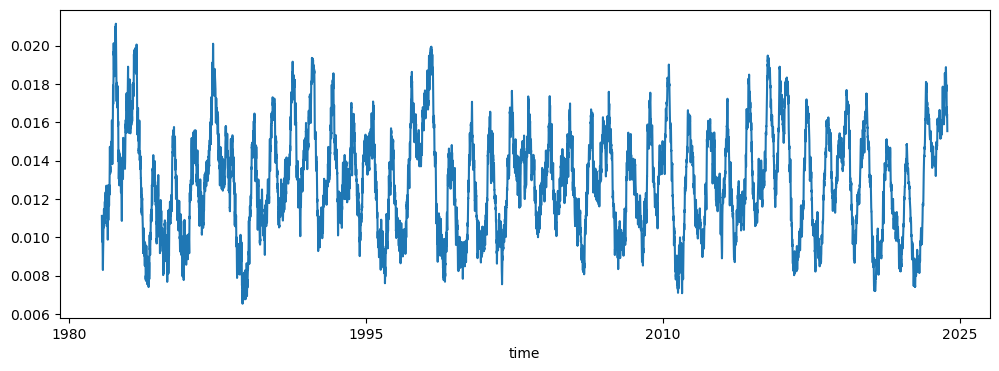

In [34]:
(tropav_weighted.tropav_weighted - tropav.tropav).plot(figsize=(12, 4))

### calculate the NINO 3.4 index 

In [35]:
ninodomain = dset.sel(lat=slice(-5, 5), lon=slice(190, 240))

In [36]:
nino34 = ninodomain.mean(dim=('lat','lon'))

In [37]:
nino34 = nino34.rename({'sst':'nino34'})

In [38]:
with ProgressBar(): 
    nino34 = nino34.compute()

[########################################] | 100% Completed | 229.65 s


Text(0.5, 1.0, 'Nino-3.4 Average Index')

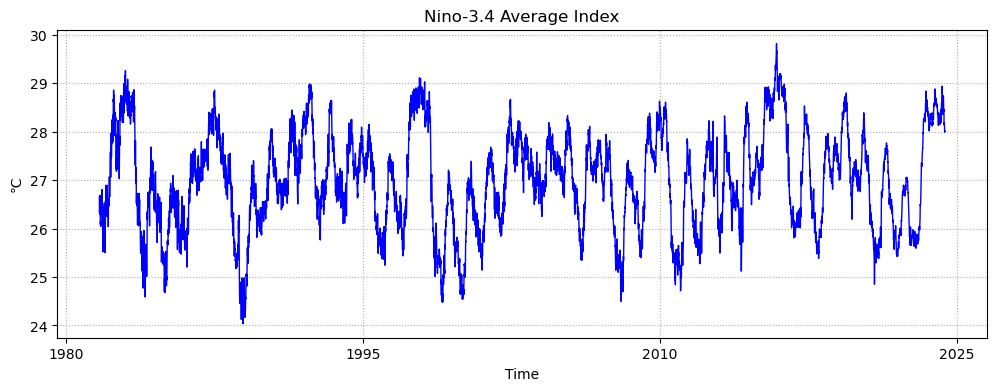

In [39]:
fig, ax = plt.subplots(figsize=(12, 4))
nino34.nino34.plot(ax=ax,x='time',linewidth=1,color='blue')
ax.grid(ls=':')
ax.set_ylabel('℃');
plt.title('Nino-3.4 Average Index')

### Calculation of the climatology, we are setting a window of 15 days (7 days each side of each day of the year) for the calculation of the climatological daily averages

In [40]:
window = 15 # needs to be an odd number 

#### setting up the climatological period 

In [41]:
climrang1 = date(1991,1,1) - relativedelta(days=(window // 2))
climrang2 = date(2020, 12, 31) + relativedelta(days=(window // 2))

In [42]:
climrang1 = cftime.datetime(*climrang1.timetuple(), calendar='365_day')

In [43]:
climrang2 = cftime.datetime(*climrang2.timetuple(), calendar='365_day')

### climatological daily averages for the NINO 3.4 index 

In [44]:
nino34_clim = nino34.sel(time=slice(climrang1, climrang2))

In [45]:
nino34_clim = nino34_clim.rolling(time=window, center=True).construct('buffer')

In [46]:
nino34_clim_ave = nino34_clim.groupby('time.dayofyear').mean(['time','buffer'])

### climatological daily averages for the weighted tropical SSTs  

In [47]:
tropav_weighted_clim = tropav_weighted.sel(time=slice(climrang1, climrang2))

In [48]:
tropav_weighted_clim = tropav_weighted_clim.rolling(time=window, center=True).construct('buffer')

In [49]:
tropav_weighted_clim_ave = tropav_weighted_clim.groupby('time.dayofyear').mean(['time','buffer'])

### plot the climatologies 

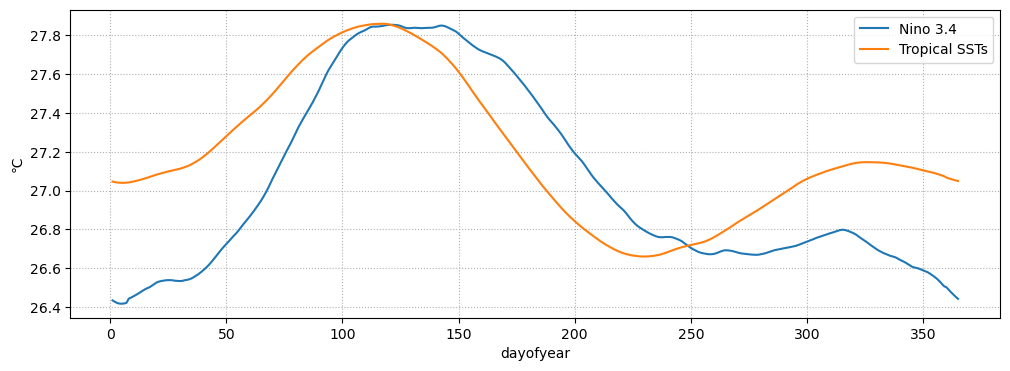

In [50]:
fig, ax = plt.subplots(figsize=(12, 4))
nino34_clim_ave['nino34'].plot(ax=ax, label='Nino 3.4')
tropav_weighted_clim_ave['tropav_weighted'].plot(ax=ax, label='Tropical SSTs')
ax.legend()
ax.grid(ls=':')
ax.set_ylabel('℃');

In [51]:
nino34_clim_ave['nino34_smoothed'] = xr_fit_harmonic(nino34_clim_ave['nino34'])

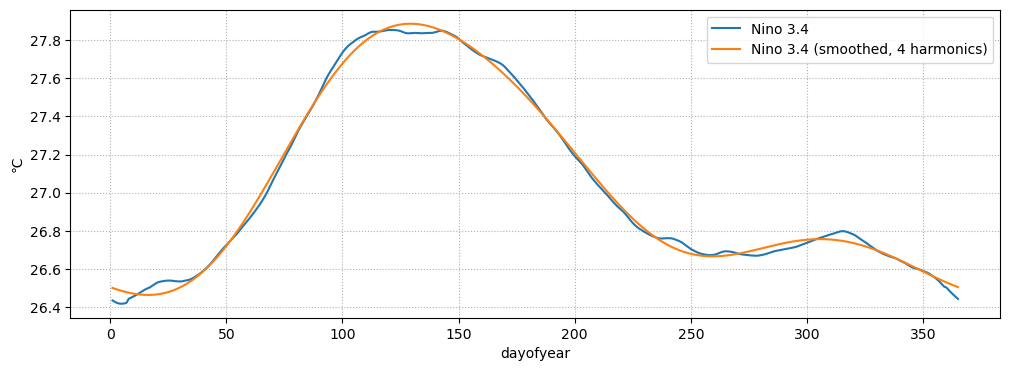

In [52]:
fig, ax = plt.subplots(figsize=(12, 4))
nino34_clim_ave['nino34'].plot(ax=ax, label='Nino 3.4')
nino34_clim_ave['nino34_smoothed'].plot(ax=ax, label='Nino 3.4 (smoothed, 4 harmonics)') 
ax.legend()
ax.grid(ls=':')
ax.set_ylabel('℃');

In [53]:
tropav_weighted_clim_ave['tropav_weighted_smoothed'] = xr_fit_harmonic(tropav_weighted_clim_ave['tropav_weighted'])

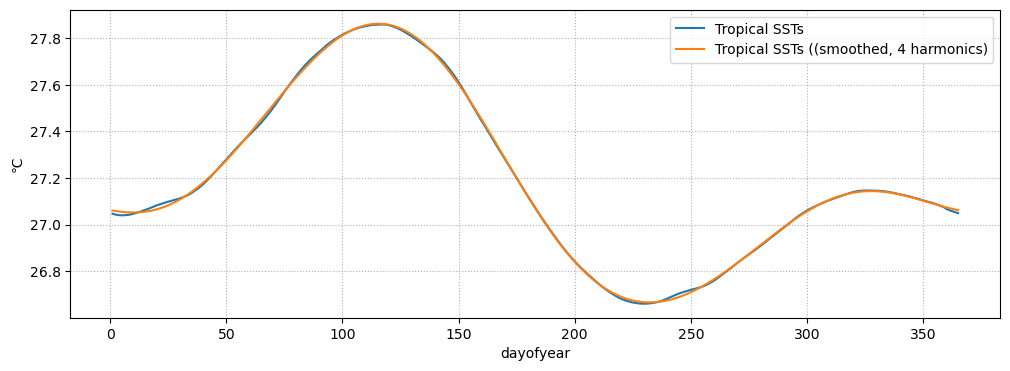

In [54]:
fig, ax = plt.subplots(figsize=(12, 4))
tropav_weighted_clim_ave['tropav_weighted'].plot(ax=ax, label='Tropical SSTs')
tropav_weighted_clim_ave['tropav_weighted_smoothed'].plot(ax=ax, label='Tropical SSTs ((smoothed, 4 harmonics)')
ax.legend()
ax.grid(ls=':')
ax.set_ylabel('℃');

### NINO3.4 anomalies WRT to climatological daily averages (smoothed)

In [55]:
nino34a = (nino34.groupby('time.dayofyear') - nino34_clim_ave['nino34_smoothed'])

### Tropical SST anomalies WRT to climatological daily averages (smoothed) 

In [56]:
tropa = (tropav_weighted.groupby('time.dayofyear') - tropav_weighted_clim_ave['tropav_weighted_smoothed'])

### Plot daily NINO 3.4 anomalies and the tropical averaged SST anomalies 

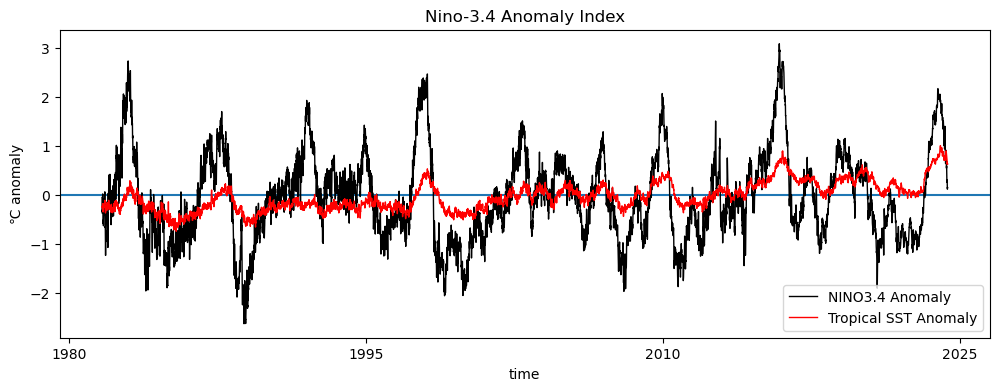

In [57]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.axhline(0)
nino34a.nino34.plot(ax=ax, x='time', linewidth=1, color='k', label='NINO3.4 Anomaly')
tropa.tropav_weighted.plot(ax=ax, x='time', linewidth=1, color='r', label='Tropical SST Anomaly')
ax.legend()
plt.title('Nino-3.4 Anomaly Index')
ax.set_ylabel('℃ anomaly');

### subtract the Tropical SST anomalies from the NINO3.4 anomalies 

In [58]:
diff_idx = nino34a['nino34'] - tropa['tropav_weighted']

In [59]:
diff_idx = diff_idx.to_dataset(name='difference_index') 

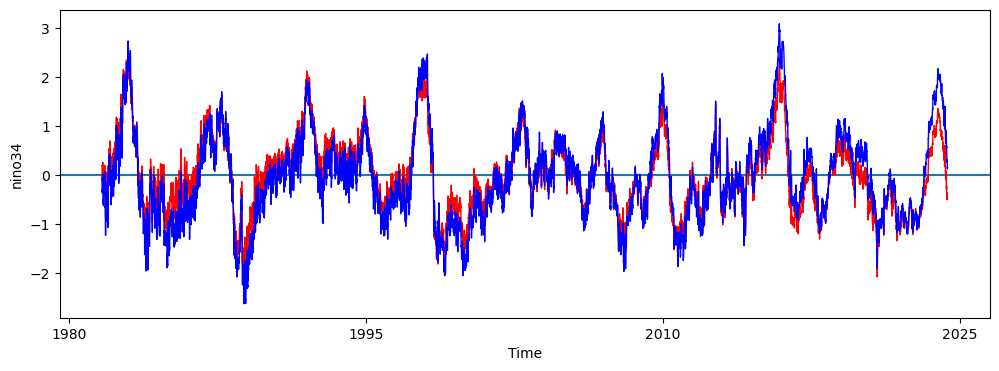

In [60]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.axhline(0)
diff_idx['difference_index'].plot(ax=ax,x='time',linewidth=1,color='r')
nino34a.nino34.plot(ax=ax,x='time',linewidth=1,color='b')

## Set scaling range

In [61]:
scalrang1 = date(1982,1,1) 
scalrang2 = date(2023, 12, 31)

## Create std. deviation climatology for Nino34 anomalies

In [62]:
nino34a_std = nino34a.rolling(time=window, center=True).construct('buffer')

In [63]:
nino34a_std = nino34a_std.groupby('time.dayofyear').std(['time','buffer'])

### smooth using 4 harmonics

In [64]:
nino34a_std['nino34_smoothed'] = xr_fit_harmonic(nino34a_std['nino34'])

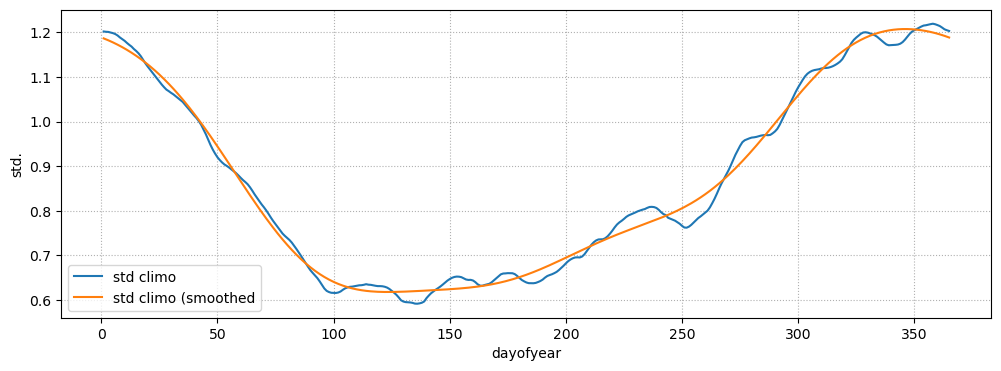

In [65]:
fig, ax = plt.subplots(figsize=(12, 4))
nino34a_std['nino34'].plot(ax=ax, label='std climo')
nino34a_std['nino34_smoothed'].plot(ax=ax, label='std climo (smoothed')
ax.legend()
ax.grid(ls=':')
ax.set_ylabel('std.');

## Create std. deviation climatology for Difference index

In [66]:
diff_idx_std = diff_idx.rolling(time=window, center=True).construct('buffer')

In [67]:
diff_idx_std = diff_idx_std.groupby('time.dayofyear').std(['time','buffer'])

### smooth using 4 harmonics

In [68]:
diff_idx_std['difference_index_smoothed'] = xr_fit_harmonic(diff_idx_std['difference_index'])

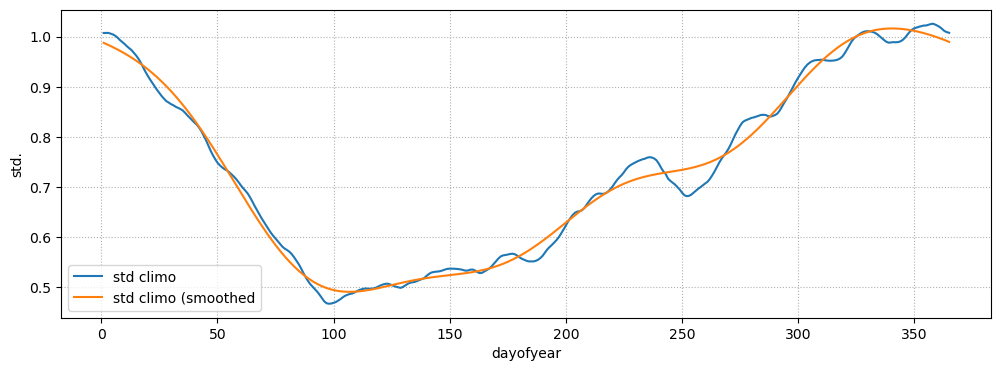

In [69]:
fig, ax = plt.subplots(figsize=(12, 4))
diff_idx_std['difference_index'].plot(ax=ax, label='std climo')
diff_idx_std['difference_index_smoothed'].plot(ax=ax, label='std climo (smoothed')
ax.legend()
ax.grid(ls=':')
ax.set_ylabel('std.');

### Now create the scaling factor 

In [70]:
scaling_factor_harm =  nino34a_std['nino34_smoothed'] / diff_idx_std['difference_index_smoothed']

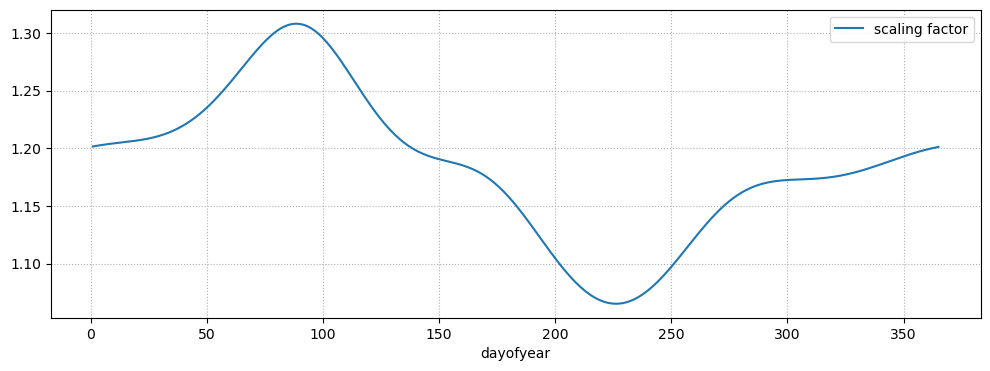

In [71]:
fig, ax = plt.subplots(figsize=(12, 4))
scaling_factor_harm.plot(ax=ax, label='scaling factor')
ax.legend()
ax.grid(ls=':')

In [72]:
scaled_reln34a = diff_idx.groupby('time.dayofyear') * scaling_factor_harm

In [73]:
scaled_reln34a = scaled_reln34a.rename({'difference_index':'relnino34a'})

### and now ... transform from a `365_day` calendar, which allowed us to avoid all kind of troubles, back to a standard calendar, any 29th Feb will just be interpolated from surrounding values ... 

In [74]:
len(scaled_reln34a.time)

15591

In [75]:
scaled_reln34a = fix_calendar(scaled_reln34a)

In [76]:
len(scaled_reln34a.time)

15602

### no missing values 

In [77]:
scaled_reln34a.isnull()['relnino34a'].sum()

<xarray.DataArray 'relnino34a' ()>
array(0)

### do the same for the 'traditional' ONI (TONI)

In [78]:
nino34a = fix_calendar(nino34a)

In [79]:
nino34a.isnull()['nino34'].sum()

<xarray.DataArray 'nino34' ()>
array(0)

### and finally for the tropical averaged SST 

In [80]:
tropa = fix_calendar(tropa)

In [81]:
tropa.isnull()['tropav_weighted'].sum()

<xarray.DataArray 'tropav_weighted' ()>
array(0)

### rename, call them RONI and TONI (Relative and Traditional Oceanic Nino Index) 

In [82]:
RONI = scaled_reln34a
RONI = RONI.rename({'relnino34a':'RONI'})

In [83]:
TONI = nino34a
TONI = TONI.rename({'nino34':'TONI'})

### Plot RONI and TONI together ... 

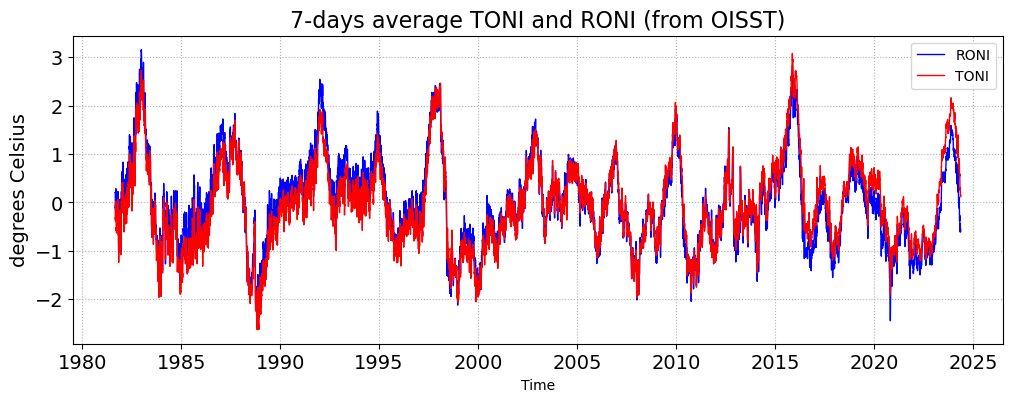

In [84]:
fig, ax = plt.subplots(figsize=(12, 4))
RONI.RONI.plot(ax=ax,x='time',linewidth=1,color='blue',label='RONI')
TONI.TONI.plot(ax=ax,x='time',linewidth=1,color='red',label='TONI')
plt.legend()
plt.ylabel('degrees Celsius')
plt.title('7-days average TONI and RONI (from OISST)', fontsize=16)
ax.grid(ls=':')
ax.set_ylabel('degrees Celsius',fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

### and plot the difference between RONI and TONI 

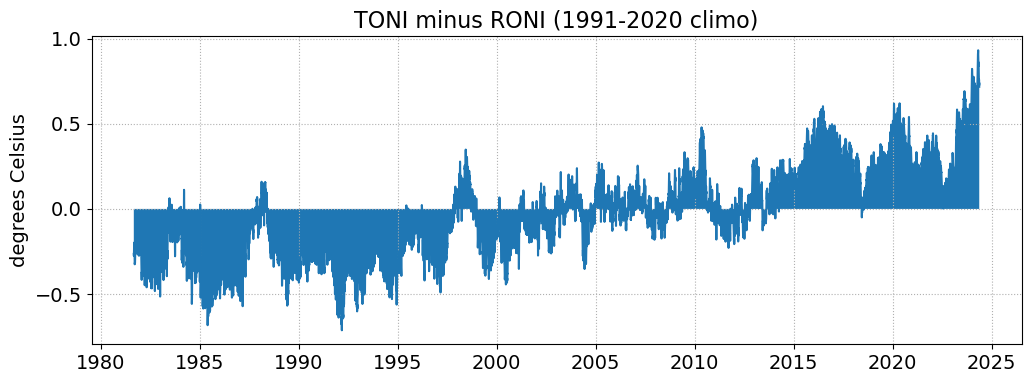

In [85]:
diff = TONI.TONI - RONI.RONI

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(diff.time, diff.values)
ax.fill_between(diff.time, diff.values, interpolate=True)
# ax.bar(diff.time, diff.values, width=19.5)
ax.set_title('TONI minus RONI (1991-2020 climo)',fontsize=16)
ax.set_ylabel('degrees Celsius',fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# ax.set_yticks(np.arange(-0.9, 0.7, step=.2))
ax.grid(ls=':')

### zoom over the period 2023 - now 

In [86]:
start_date = '2023-01-01'

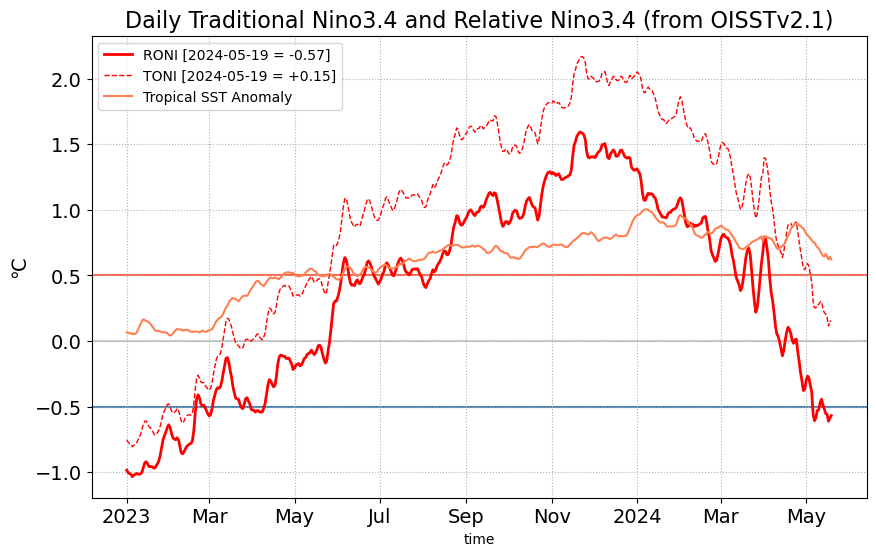

In [87]:
fig, ax = plt.subplots(figsize=(10, 6))


RONI.sel(time=slice(start_date,None)).RONI.plot(ax=ax,x='time',linewidth=2,color='red',label=f"RONI [{RONI.time.to_index()[-1]:%Y-%m-%d} = {RONI.RONI.data[-1]:+4.2f}]")
TONI.sel(time=slice(start_date,None)).TONI.plot(ax=ax,x='time',linewidth=1,color='red',linestyle='dashed',label=f"TONI [{TONI.time.to_index()[-1]:%Y-%m-%d} = {TONI.TONI.data[-1]:+4.2f}]")
tropa.sel(time=slice(start_date,None)).tropav_weighted.plot(ax=ax, x='time', linewidth=1.5, color='coral', label='Tropical SST Anomaly')

ax.legend()

ax.set_title('Daily Traditional Nino3.4 and Relative Nino3.4 (from OISSTv2.1)', fontsize=16)

ax.grid(ls=':')
ax.axhline(+0.5, color='tomato', zorder=-1)
ax.axhline(-0.5, color='steelblue', zorder=-1)
ax.axhline(0, color='0.8', zorder=-1)

ax.set_ylabel('℃',fontsize=14)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)